In [1]:
!pip install snntorch

In [2]:
# imports
import snntorch as snn
from snntorch import surrogate
from snntorch import backprop
from snntorch import functional as SF
from snntorch import utils
from snntorch import spikeplot as splt

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.nn.functional as F

import matplotlib.pyplot as plt
import numpy as np
import itertools

C:\Users\loaiu\AppData\Local\Temp\ipykernel_35132\3569606770.py:4: DeprecationWarning: The module snntorch.backprop will be deprecated in  a future release. Writing out your own training loop will lead to substantially faster performance.
  from snntorch import backprop


In [3]:
# List the available devices:
print("Available devices:")
print(torch.cuda.device_count())
print("List of devices:")
print(torch.cuda.device(0))
print(torch.cuda.get_device_name(0))
#print(torch.cuda.device(1))            KAGLE
#print(torch.cuda.get_device_name(1))   KAGLE

Available devices:
1
List of devices:
NVIDIA GeForce RTX 3050 Ti Laptop GPU


In [4]:
# using gpus if available
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#print(device)
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"  # to 1 both GPUs

In [5]:
spike_grad = surrogate.fast_sigmoid(slope=25) # SpikeGrad surrogate function
beta = 0.5 # Decay factor

lif1 = snn.Leaky(beta=beta, spike_grad=spike_grad) # Leaky integrate-and-fire neuron

In [6]:
# dataloader arguments
batch_size = 128
data_path='/tmp/data/mnist'

dtype = torch.float

In [7]:
# Define a transform
transform = transforms.Compose([
            transforms.Resize((28, 28)),
            transforms.Grayscale(),
            transforms.ToTensor(),
            transforms.Normalize((0,), (1,))])

mnist_train = datasets.MNIST(data_path, train=True, download=True, transform=transform)
mnist_test = datasets.MNIST(data_path, train=False, download=True, transform=transform)

# Create DataLoaders
train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=True, drop_last=True)

In [8]:
# neuron and simulation parameters
spike_grad = surrogate.fast_sigmoid(slope=25)
beta = 0.5
num_steps = 50

In [9]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()

        # Initialize layers
        self.conv1 = nn.Conv2d(1, 12, 5)
        self.lif1 = snn.Leaky(beta=beta, spike_grad=spike_grad)
        self.conv2 = nn.Conv2d(12, 64, 5)
        self.lif2 = snn.Leaky(beta=beta, spike_grad=spike_grad)
        self.fc1 = nn.Linear(64*4*4, 10)
        self.lif3 = snn.Leaky(beta=beta, spike_grad=spike_grad)

    def forward(self, x):

        # Initialize hidden states and outputs at t=0
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()
        mem3 = self.lif3.init_leaky()

        cur1 = F.max_pool2d(self.conv1(x), 2)
        spk1, mem1 = self.lif1(cur1, mem1)

        cur2 = F.max_pool2d(self.conv2(spk1), 2)
        spk2, mem2 = self.lif2(cur2, mem2)

        cur3 = self.fc1(spk2.view(batch_size, -1))
        spk3, mem3 = self.lif3(cur3, mem3)

        return spk3, mem3

In [10]:
# Better performance
net = nn.Sequential(nn.Conv2d(1, 12, 5),
                    nn.MaxPool2d(2),
                    snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True),
                    nn.Conv2d(12, 64, 5),
                    nn.MaxPool2d(2),
                    snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True),
                    nn.Flatten(),
                    nn.Linear(64*4*4, 10),
                    snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True, output=True)
                    ).cuda()

In [11]:
data, targets = next(iter(train_loader))
data = data.cuda()
targets = targets.cuda()

for step in range(num_steps):
    spk_out, mem_out = net(data)

In [12]:
def forward_pass(net, num_steps, data):
  mem_rec = []
  spk_rec = []
  utils.reset(net)  # resets hidden states for all LIF neurons in net

  for step in range(num_steps):
      spk_out, mem_out = net(data)
      spk_rec.append(spk_out)
      mem_rec.append(mem_out)

  return torch.stack(spk_rec), torch.stack(mem_rec)

In [13]:
# already imported snntorch.functional as SF
loss_fn = SF.ce_rate_loss()

In [14]:
def batch_accuracy(train_loader, net, num_steps):
  with torch.no_grad():
    total = 0
    acc = 0
    net.eval()

    train_loader = iter(train_loader)
    for data, targets in train_loader:
      data = data.cuda()
      targets = targets.cuda()
      spk_rec, _ = forward_pass(net, num_steps, data)

      acc += SF.accuracy_rate(spk_rec, targets) * spk_rec.size(1)
      total += spk_rec.size(1)

  return acc/total

test_acc = batch_accuracy(test_loader, net, num_steps)
print("Initial Accuracy : ", test_acc * 100, '%')

Initial Accuracy :  9.805689102564102 %


In [15]:
import tqdm
optimizer = torch.optim.Adam(net.parameters(), lr=1e-2, betas=(0.9, 0.999))
num_epochs = 1
loss_hist = []
test_acc_hist = []
counter = 0

# Outer training loop
for epoch in tqdm.trange(num_epochs):
    # Training loop
    for data, targets in iter(train_loader):
        data = data.cuda()
        targets = targets.cuda()

        # forward pass
        net.train()
        spk_rec, _ = forward_pass(net, num_steps, data)

        # initialize the loss & sum over time
        loss_val = loss_fn(spk_rec, targets)

        # Gradient calculation + weight update
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()

        # Store loss history for future plotting
        loss_hist.append(loss_val.item())

        # Test set
        if counter % 50 == 0:
            with torch.no_grad():
                net.eval()
                
                test_acc = batch_accuracy(test_loader, net, num_steps)
                print(f"Iteration {counter}, Test Acc: {test_acc * 100:.2f}%\n")
                test_acc_hist.append(test_acc.item())

        counter += 1

  0%|          | 0/1 [00:00<?, ?it/s]

Iteration 0, Test Acc: 9.80%

Iteration 50, Test Acc: 93.37%

Iteration 100, Test Acc: 94.95%

Iteration 150, Test Acc: 96.55%

Iteration 200, Test Acc: 97.02%

Iteration 250, Test Acc: 97.12%

Iteration 300, Test Acc: 96.46%

Iteration 350, Test Acc: 97.59%

Iteration 400, Test Acc: 97.35%

Iteration 450, Test Acc: 96.72%



100%|██████████| 1/1 [04:35<00:00, 275.99s/it]


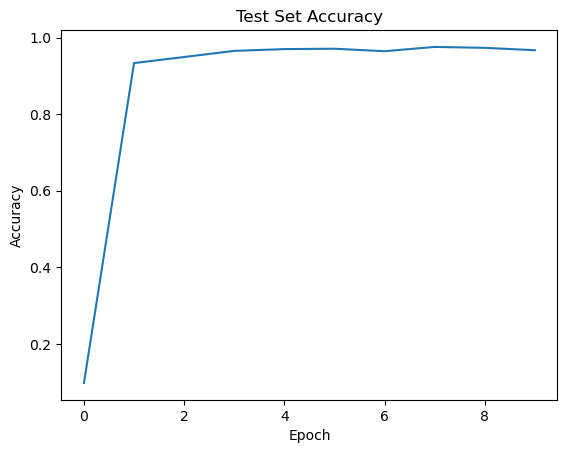

In [16]:
# Plot Loss
fig = plt.figure(facecolor="w")
plt.plot(test_acc_hist)
plt.title("Test Set Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

In [17]:
spk_rec, mem_rec = forward_pass(net, num_steps, data)

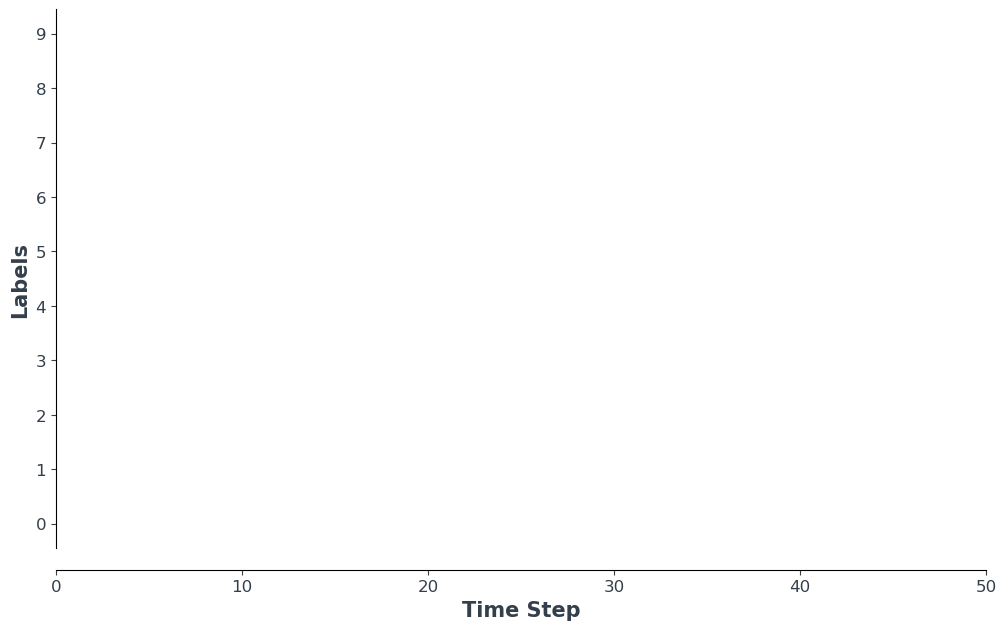

In [18]:
from IPython.display import HTML

idx = 0

fig, ax = plt.subplots(facecolor='w', figsize=(12, 7))
labels=['0', '1', '2', '3', '4', '5', '6', '7', '8','9']

# plt.rcParams['animation.ffmpeg_path'] = 'C:\\path\\to\\your\\ffmpeg.exe'

#  Plot spike count histogram
anim = splt.spike_count(spk_rec[:, idx].detach().cpu(), fig, ax, labels=labels,
                        animate=True, interpolate=4)

HTML(anim.to_html5_video())
# anim.save("spike_bar.mp4")

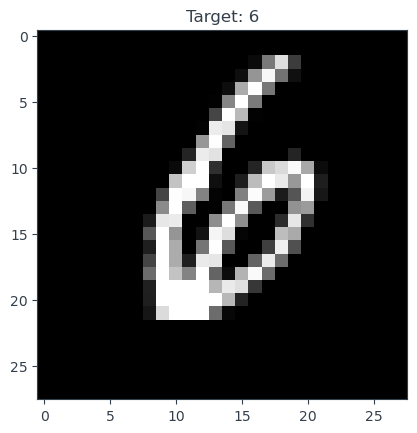

In [19]:
plt.imshow(data[idx].cpu().squeeze(), cmap='gray')
plt.title(f"Target: {targets[idx]}")
plt.show()

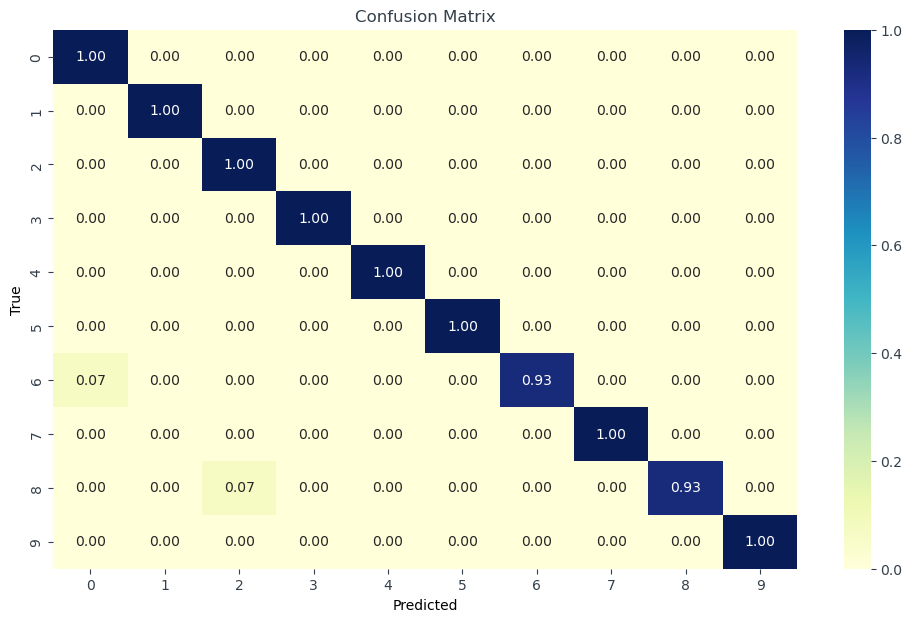

In [24]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

for data, targets in test_loader:
    data = data.cuda()
    targets = targets.cuda()
    spk_rec, _ = forward_pass(net, num_steps, data)

    pred = spk_rec.sum(0).argmax(1)
    targets = targets.cpu().numpy()

    cm = confusion_matrix(targets, pred.cpu().numpy())
    cm = cm / cm.sum(1, keepdims=True)

    fig, ax = plt.subplots(facecolor='w', figsize=(12, 7))
    sns.heatmap(cm, annot=True, fmt=".2f", cmap="YlGnBu", xticklabels=labels, yticklabels=labels, ax=ax)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()
    break
